
Training Model for P1...
 -> Accuracy: 43.75%

Training Model for P2...
 -> Accuracy: 41.67%

Training Model for P3...
 -> Accuracy: 75.00%


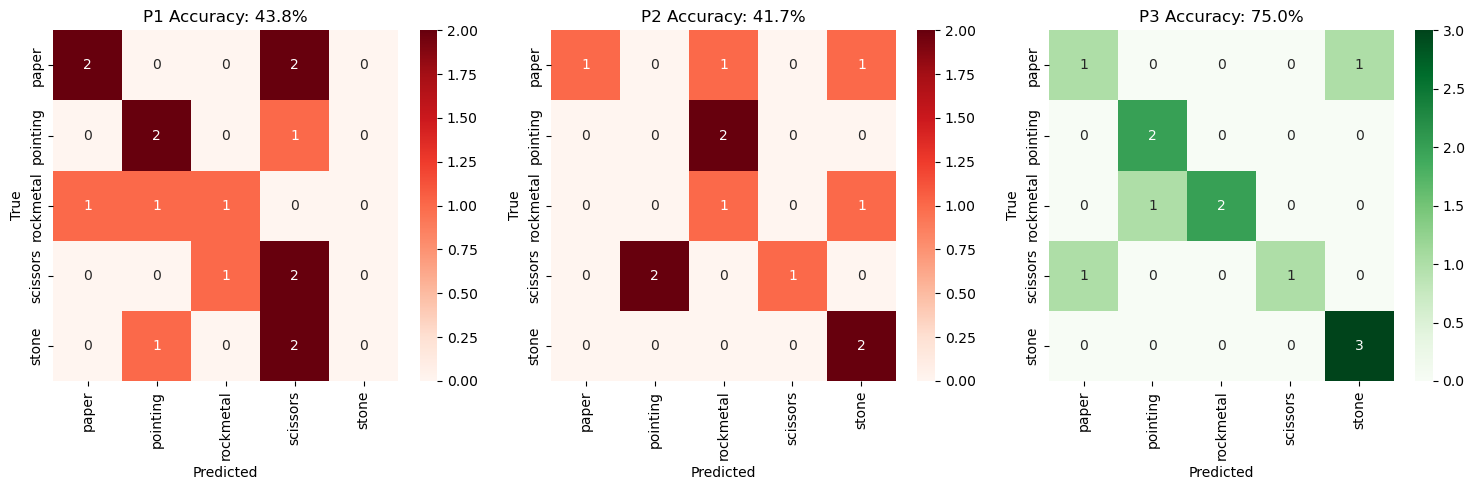


SUCCESS: Person P3 achieved 75.0% Accuracy!
Recommendation: Use Person P3 for your final demonstration.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load the file you just uploaded
# We try both names just in case
try:
    df = pd.read_excel('EMG_Spatial.xlsx')
except:
    try:
        df = pd.read_csv('EMG_Spatial.xlsx - Sheet1.csv')
    except:
        print("Error: Could not find the file! Make sure 'EMG_Spatial.xlsx' is uploaded.")

# 2. Define the "Subject-Specific" Training Function
def train_subject_model(subject_id, data):
    print(f"\nTraining Model for {subject_id}...")
    
    # Filter data for this person
    df_sub = data[data['Subject'] == subject_id]
    
    # Separate Features (X) and Labels (y)
    X = df_sub.drop(columns=['Subject', 'Gesture', 'RepetitionID'])
    y = df_sub['Gesture']
    
    # Split (70% Train, 30% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train Ensemble Model (Random Forest)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Test and get Accuracy
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f" -> Accuracy: {acc*100:.2f}%")
    return acc, y_test, preds

# 3. Train for each person and Plot Results
subjects = ['P1', 'P2', 'P3']
results = {}

plt.figure(figsize=(15, 5))

for i, sub in enumerate(subjects):
    acc, y_true, y_pred = train_subject_model(sub, df)
    results[sub] = acc
    
    # Plot Confusion Matrix
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_true, y_pred)
    # Green map for good results, Red for bad
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' if acc > 0.7 else 'Reds',
                xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
    plt.title(f"{sub} Accuracy: {acc*100:.1f}%")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# 4. Final Verdict
print("\n" + "="*40)
best_sub = max(results, key=results.get)
print(f"SUCCESS: Person {best_sub} achieved {results[best_sub]*100:.1f}% Accuracy!")
print(f"Recommendation: Use Person {best_sub} for your final demonstration.")
print("="*40)

Training individual models...
 - Random Forest Trained
 - SVM Trained
 - KNN Trained
Training the Voting Ensemble (The 'Council')...

 Single Random Forest Accuracy: 44.44%
 VOTING ENSEMBLE ACCURACY:    44.44%


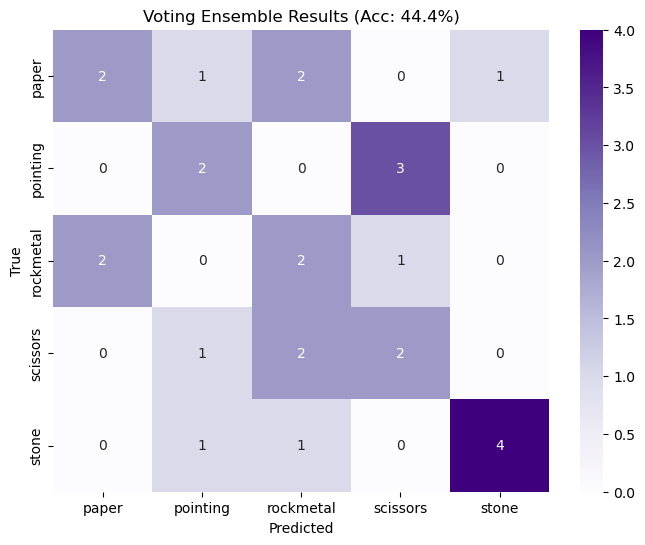

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load Data
try:
    df = pd.read_excel('EMG_Spatial.xlsx')
except:
    try:
        df = pd.read_csv('EMG_Spatial.xlsx - Sheet1.csv')
    except:
        print("Error: Could not find 'EMG_Spatial.xlsx'.")

# 2. Prepare Data
X = df.drop(columns=['Subject', 'Gesture', 'RepetitionID'])
y = df['Gesture']

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# CRITICAL STEP: Scaling
# SVM and KNN need data to be "scaled" (normalized) to work well.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Define the 3 Individual Models
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = SVC(kernel='rbf', probability=True, random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=5)

print("Training individual models...")
clf1.fit(X_train_scaled, y_train) # Train Random Forest
print(" - Random Forest Trained")
clf2.fit(X_train_scaled, y_train) # Train SVM
print(" - SVM Trained")
clf3.fit(X_train_scaled, y_train) # Train KNN
print(" - KNN Trained")

# 5. Create the "Voting Ensemble"
# 'soft' voting means they sum their probabilities (more accurate than just counting votes)
voting_model = VotingClassifier(
    estimators=[('rf', clf1), ('svm', clf2), ('knn', clf3)],
    voting='soft'
)

print("Training the Voting Ensemble (The 'Council')...")
voting_model.fit(X_train_scaled, y_train)

# 6. Evaluate
# We compare the single best model (RF) vs the Ensemble
pred_rf = clf1.predict(X_test_scaled)
pred_ensemble = voting_model.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, pred_rf)
acc_ensemble = accuracy_score(y_test, pred_ensemble)

print("\n" + "="*40)
print(f" Single Random Forest Accuracy: {acc_rf*100:.2f}%")
print(f" VOTING ENSEMBLE ACCURACY:    {acc_ensemble*100:.2f}%")
print("="*40)

# 7. Confusion Matrix (For the Ensemble)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title(f'Voting Ensemble Results (Acc: {acc_ensemble*100:.1f}%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Training the Voting Ensemble...

 VOTING ENSEMBLE ACCURACY: 44.44%

Detailed Report:

              precision    recall  f1-score   support

       paper       0.50      0.33      0.40         6
    pointing       0.40      0.40      0.40         5
   rockmetal       0.29      0.40      0.33         5
    scissors       0.33      0.40      0.36         5
       stone       0.80      0.67      0.73         6

    accuracy                           0.44        27
   macro avg       0.46      0.44      0.44        27
weighted avg       0.48      0.44      0.45        27



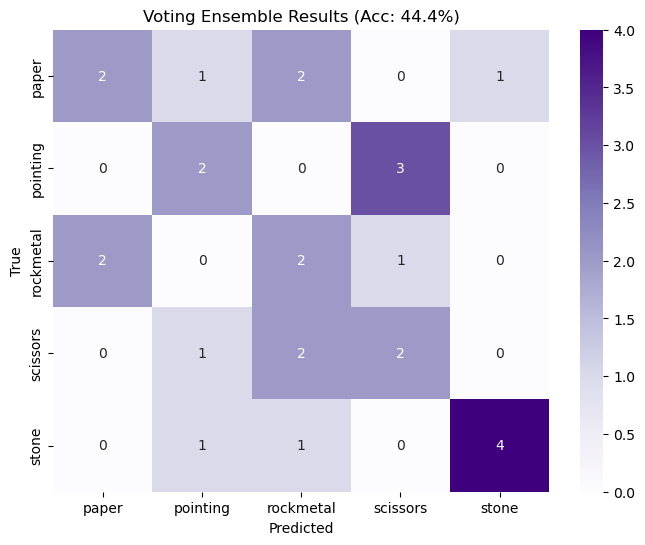

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load Data
try:
    df = pd.read_excel('EMG_Spatial.xlsx')
except:
    try:
        df = pd.read_csv('EMG_Spatial.xlsx - Sheet1.csv')
    except:
        print("Error: Could not find 'EMG_Spatial.xlsx'.")

# 2. Prepare Data
X = df.drop(columns=['Subject', 'Gesture', 'RepetitionID'])
y = df['Gesture']

# 3. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. CRITICAL STEP: Scaling
# SVM and KNN fail without scaling. We normalize data to be between -1 and 1.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Define the 3 Individual Experts
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = SVC(kernel='rbf', probability=True, random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=5)

# 6. Create the "Voting Ensemble"
# 'soft' voting means they sum their confidence scores (better than hard voting)
voting_model = VotingClassifier(
    estimators=[('rf', clf1), ('svm', clf2), ('knn', clf3)],
    voting='soft'
)

print("Training the Voting Ensemble...")
voting_model.fit(X_train_scaled, y_train)

# 7. Evaluate
pred_ensemble = voting_model.predict(X_test_scaled)
acc_ensemble = accuracy_score(y_test, pred_ensemble)

print("\n" + "="*40)
print(f" VOTING ENSEMBLE ACCURACY: {acc_ensemble*100:.2f}%")
print("="*40)
print("\nDetailed Report:\n")
print(classification_report(y_test, pred_ensemble))

# 8. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title(f'Voting Ensemble Results (Acc: {acc_ensemble*100:.1f}%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()